In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

import pickle

In [2]:
BASE_DIR  = 'C:/Users/jp601/Detect_Age_Gender/archive/UTKFace'

In [3]:
#labels age, gender , ethnicity

image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
# Conver to data frame
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,C:/Users/jp601/Detect_Age_Gender/archive/UTKFa...,100,0
1,C:/Users/jp601/Detect_Age_Gender/archive/UTKFa...,100,0
2,C:/Users/jp601/Detect_Age_Gender/archive/UTKFa...,100,1
3,C:/Users/jp601/Detect_Age_Gender/archive/UTKFa...,100,1
4,C:/Users/jp601/Detect_Age_Gender/archive/UTKFa...,100,1


In [5]:
gender_dict = {0:'Male',1:'Female '}

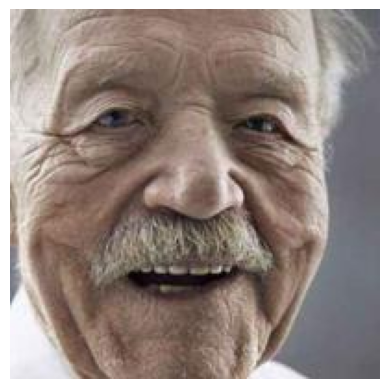

In [6]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

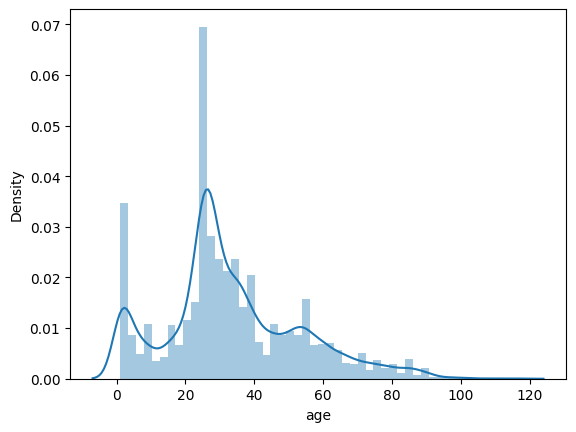

In [7]:
sns.distplot(df['age'])

<Axes: xlabel='gender', ylabel='count'>

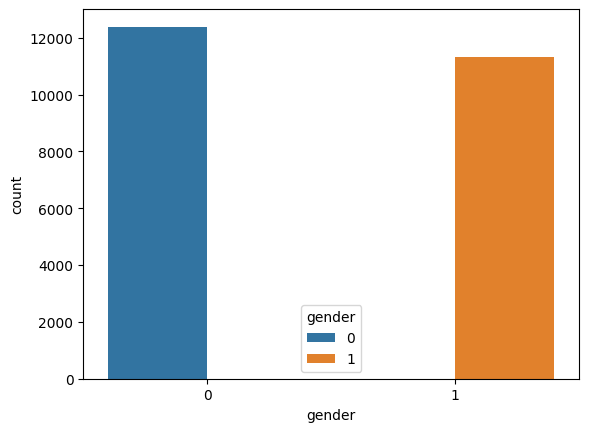

In [8]:
sns.countplot(data=df, x='gender', hue='gender')

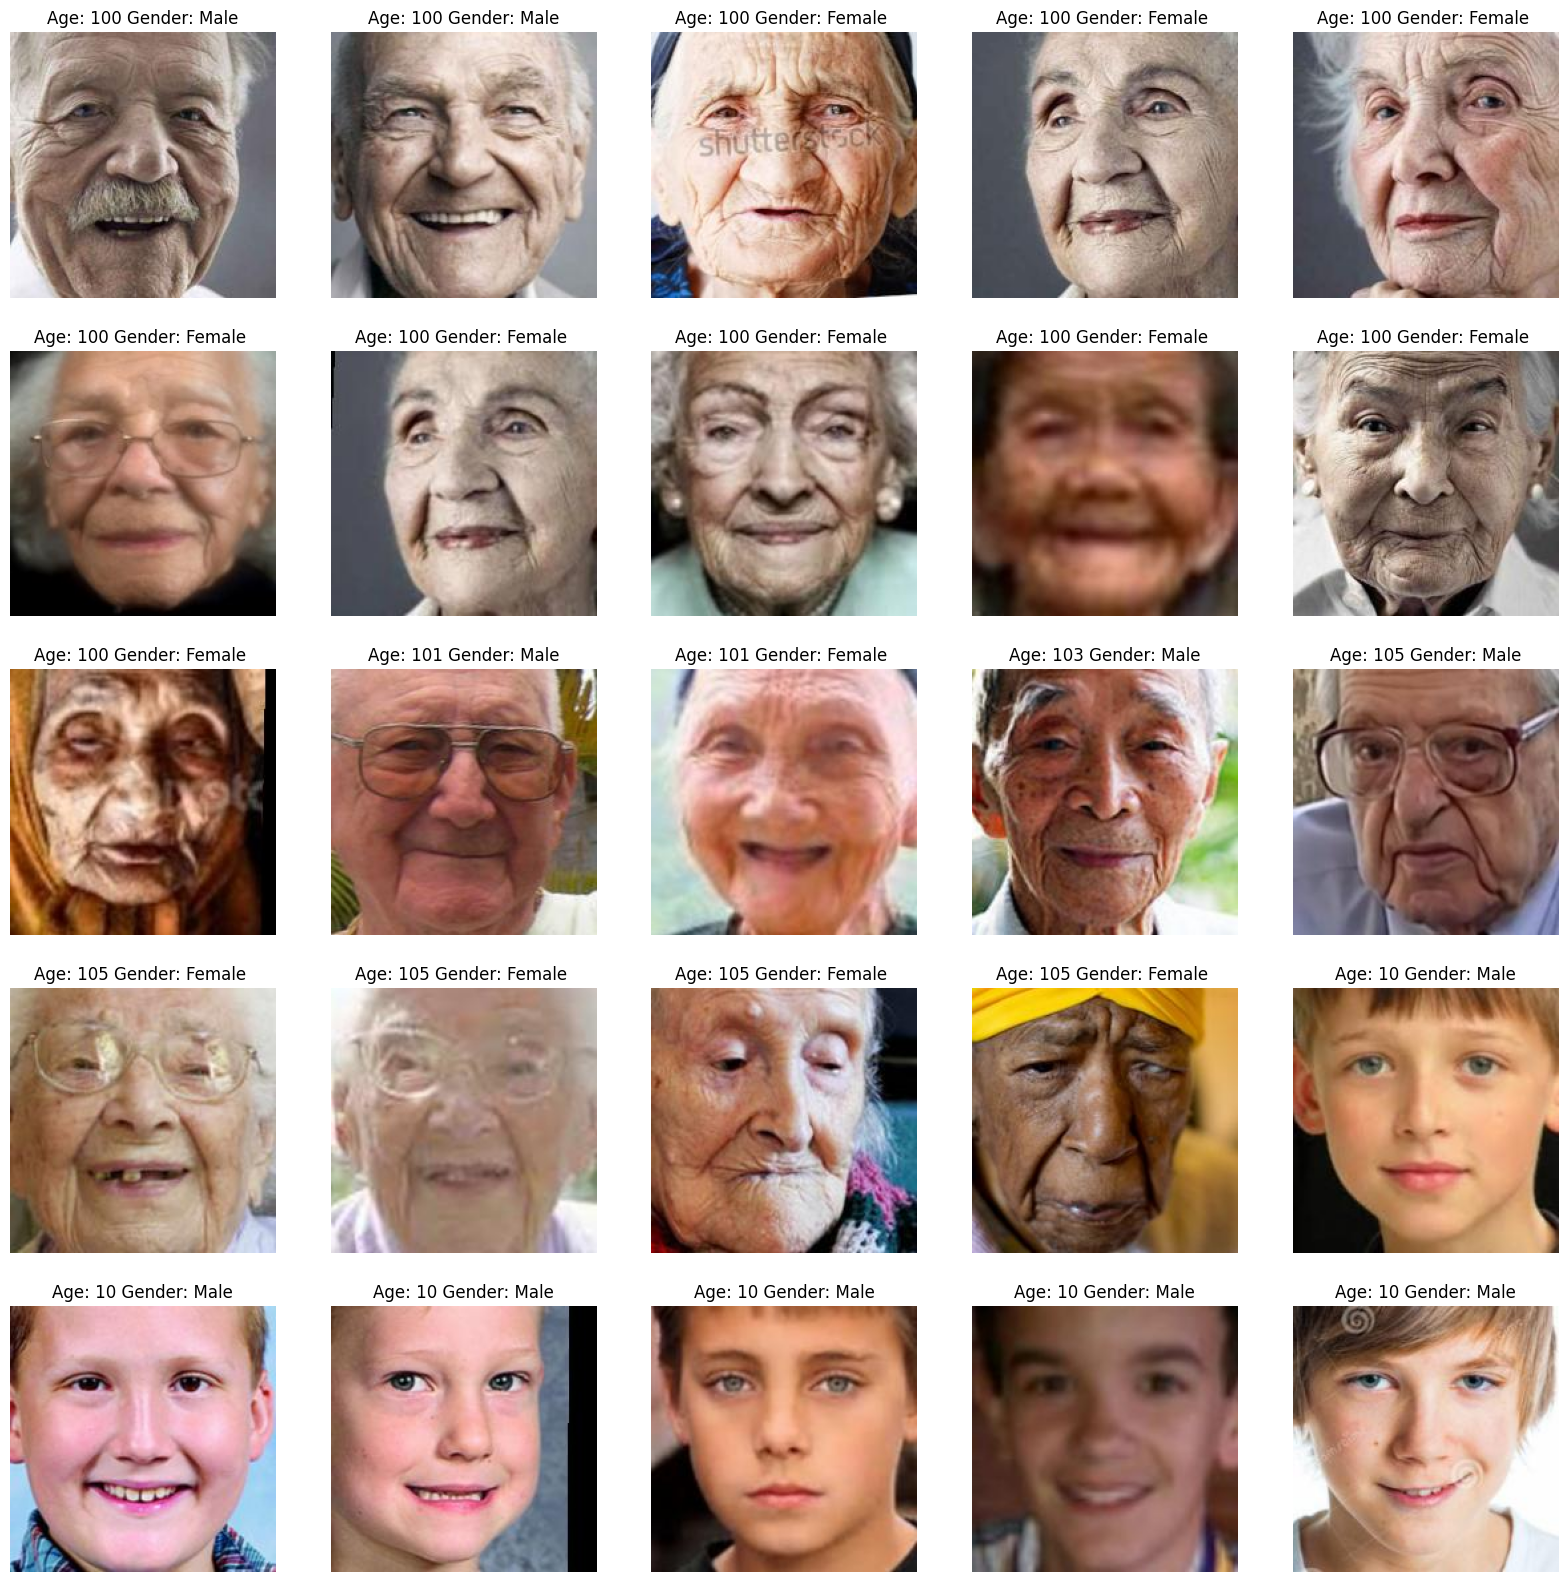

In [9]:
plt.figure(figsize = (20,20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [10]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale = True)
        img = img.resize((128,128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [11]:
x = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [12]:
x.shape

(23708, 128, 128, 1)

In [13]:
x = x/255.0

In [14]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [15]:
input_shape = (128, 128, 1)

In [16]:
inputs = Input((input_shape))

# Convolutional layers
conv_1 = Conv2D(32, kernel_size = (3,3), activation = 'relu') (inputs)
maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
conv_2 = Conv2D(64, kernel_size = (3,3), activation = 'relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size = (2,2)) (conv_2)
conv_3 = Conv2D(128, kernel_size = (3,3), activation = 'relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size = (2,2)) (conv_3)
conv_4 = Conv2D(256, kernel_size = (3,3), activation = 'relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size = (2,2)) (conv_4)

flatten = Flatten() (maxp_4)

#Fully connected layers

dense_1 = Dense(256, activation = 'relu') (flatten)
dense_2 = Dense(256, activation = 'relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation = 'sigmoid', name = 'gender_out') (dropout_1)
output_2 = Dense(1, activation = 'relu', name = 'age_out') (dropout_2)

model = Model(inputs = [inputs], outputs = [output_1, output_2])
model.compile(loss= ['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
#train model
history = model.fit(x =x , y = [y_gender, y_age], batch_size= 32, epochs= 30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 438s 738ms/step - loss: 2.9680 - gender_out_loss: 0.0796 - age_out_loss: 2.8884 - gender_out_accuracy: 0.9634 - age_out_accuracy: 0.0578 - val_loss: 20.0690 - val_gender_out_loss: 0.9272 - val_age_out_loss: 19.1418 - val_gender_out_accuracy: 0.8294 - val_age_out_accuracy: 0.0000e+00
Epoch 2/30
593/593 [==============================] - 416s 702ms/step - loss: 2.9519 - gender_out_loss: 0.0768 - age_out_loss: 2.8751 - gender_out_accuracy: 0.9643 - age_out_accuracy: 0.0579 - val_loss: 18.0524 - val_gender_out_loss: 0.9340 - val_age_out_loss: 17.1184 - val_gender_out_accuracy: 0.8345 - val_age_out_accuracy: 0.0000e+00
Epoch 3/30
593/593 [==============================] - 398s 672ms/step - loss: 2.9217 - gender_out_loss: 0.0719 - age_out_loss: 2.8498 - gender_out_accuracy: 0.9678 - age_out_accuracy: 0.0582 - val_loss: 19.1931 - val_gender_out_loss: 0.8822 - val_age_out_loss: 18.3109 - val_gender_out_accuracy: 0.8340 - val_age_out_accurac

593/593 [==============================] - 330s 557ms/step - loss: 2.5011 - gender_out_loss: 0.0444 - age_out_loss: 2.4567 - gender_out_accuracy: 0.9790 - age_out_accuracy: 0.0586 - val_loss: 20.5315 - val_gender_out_loss: 1.2712 - val_age_out_loss: 19.2603 - val_gender_out_accuracy: 0.8281 - val_age_out_accuracy: 0.0000e+00
Epoch 26/30
593/593 [==============================] - 341s 575ms/step - loss: 2.5177 - gender_out_loss: 0.0436 - age_out_loss: 2.4741 - gender_out_accuracy: 0.9795 - age_out_accuracy: 0.0584 - val_loss: 18.6839 - val_gender_out_loss: 1.2949 - val_age_out_loss: 17.3890 - val_gender_out_accuracy: 0.8283 - val_age_out_accuracy: 0.0000e+00
Epoch 27/30
593/593 [==============================] - 346s 584ms/step - loss: 2.5157 - gender_out_loss: 0.0416 - age_out_loss: 2.4741 - gender_out_accuracy: 0.9805 - age_out_accuracy: 0.0585 - val_loss: 18.7192 - val_gender_out_loss: 1.1868 - val_age_out_loss: 17.5324 - val_gender_out_accuracy: 0.8349 - val_age_out_accuracy: 0.0000

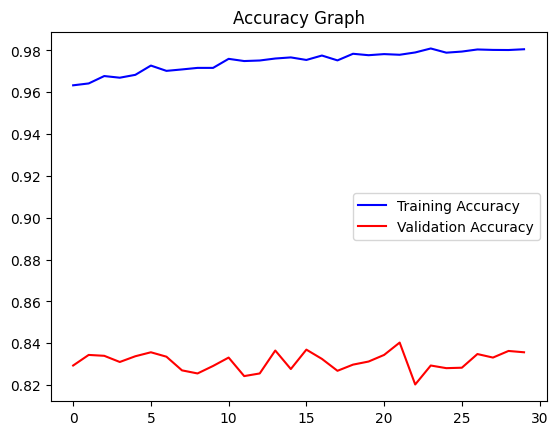

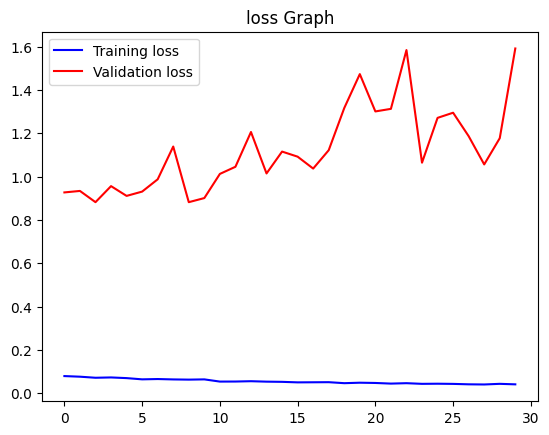

In [21]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('loss Graph')
plt.legend()
plt.show()

In [23]:
with open('Name_Age_Gender.pkl', 'wb') as file:
    pickle.dump(model, file)

In [8]:
import cv2 
import pickle

# Load the trained model
with open('C:/Users/jp601/Detect_Age_Gender/Name_Age_Gender.pkl', 'rb') as file:
    model = pickle.load(file)

    
classifier = cv2.CascadeClassifier('C:/Users/jp601/Downloads/haarcascade_frontalface_default.xml')

# Set up the webcam stream
webcam = cv2.VideoCapture(0)

def preprocess_frame(frame):
    try:
        test_features= []
        faces = classifier.detectMultiScale(frame, 1.1, 5) #(source,scaling_factor,min_neighbours)
        for f in faces:                                   #Going through each face detected 
            if f[-1] == max(faces[:,-1]):                 #Finding the face of max Area
                break
        
    
        if len(faces) >= 1:                              #Drawing rectangle on the face
            x = f[0]
            y = f[1]
            w = f[2]
            h = f[3]
        
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,180,0),2)#(source,coordinates,colour,thickness)
            face = frame[y:y+h,x:x+w]
            face = cv.cvtColor(face, cv.COLOR_BGR2GRAY)
            face = face.resize(input_shape, Image.LANCZOS)
            face = np.array(face)
            test_features.append(face)
            
            test_features = np.array(test_features)
            test_features = test_features.reshape(1, 128, 128, 1)
            
            test_features = test_features/255.0
            
            return test_featues
        
            
    except:
        pass
    

while True:
    # Capture frame-by-frame
    ret, frame = webcam.read()
    frame = cv2.flip(frame,1)

    # Preprocess the frame (resize, normalization, etc.)
    preprocessed_frame = preprocess_frame(frame)

#     # Make predictions using the model
#     age_prediction, gender_prediction = model.predict(preprocessed_frame)

#     # Display the results on the frame
#     display_results(frame, age_prediction, gender_prediction)

    pred = model.predict(preprocessed_frame)
    pred_gender = gender_dict[round(pred[0][0][0])]
    pred_age = round(pred[1][0][0])
    
    print("Predicted Age: ",pred_age, "predicted gender: ", pred_gender)
    plt.axis('off')
    plt.imshow(preprocessed_frame.reshape(128,128), cmap = 'gray')

    # Show the frame with results
    cv2.imshow('Webcam', frame)
    
    
    
    

    # Press 'q' to exit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the OpenCV windows
webcam.release()
cv2.destroyAllWindows()


ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>